In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from astropy import units as u
from astropy import constants as c
from pygsm import GlobalSkyModel2016, GlobalSkyModel

/Users/jaguirre/anaconda3/envs/hera/lib/python2.7/site-packages/healpy/sphtfunc.py:28: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _sphtools as _sphtools
/Users/jaguirre/anaconda3/envs/hera/lib/python2.7/site-packages/healpy/sphtfunc.py:28: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from . import _sphtools as _sphtools
/Users/jaguirre/anaconda3/envs/hera/lib/python2.7/site-packages/healpy/__init__.py:47: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._query_disc import query_disc, query_strip, query_polygon, boundaries
/Users/jaguirre/anaconda3/envs/hera/lib/python2.7/site-packages/healpy/__init__.py:47: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from ._query_disc import query_disc, query_strip, query_polygon, boundaries
/Users/jaguirre/an

In [2]:
maps = []
freqs = np.linspace(100,200,num=10)*u.MHz
for f in freqs:
    gsm = GlobalSkyModel(freq_unit='MHz')
    gsm.generate(f)
    maps.append(gsm.generated_map_data)

In [5]:
%matplotlib qt
hp.mollview(np.log10(maps[0]),title='',notext=True,cbar=False)
#plt.savefig('GSM150MHzEQ.png')
plt.show()

In [14]:
hp.mollzoom(maps[0])

In [14]:
npix = len(maps[0])
nside = hp.npix2nside(npix)
print nside

512


In [7]:
ipix_gc = hp.ang2pix(nside,np.pi/2.,0.)

In [8]:
ipix_gc

1569792

In [9]:
disc_gc = hp.query_disc(nside,hp.ang2vec(np.pi/2.,0.),np.radians(1.0),inclusive=True)

In [11]:
gc_spec_pt = []
gc_spec_disc = []
for m in maps:
    gc_spec_pt.append(m[ipix_gc])
    gc_spec_disc.append(m[disc_gc].mean())
gc_spec_pt = np.array(gc_spec_pt)*u.K
gc_spec_disc = np.array(gc_spec_disc)*u.K

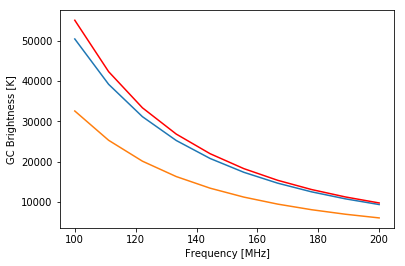

In [36]:
%matplotlib inline
plt.plot(freqs,gc_spec_pt)
plt.plot(freqs,gc_spec_disc)
plt.plot(freqs,2.e4*np.power(freqs/150.,-2.5),color='red')
plt.ylabel('GC Brightness [K]')
plt.xlabel('Frequency [MHz]')
plt.show()

In [37]:
# What's the HERA19 synthesized beam?  Could pull from psf produced by CASA, but let's make a guess
lmbda = (c.c/freqs).to(u.m)
b_max = 58.*u.m
FWHM = (lmbda/b_max)*u.radian
omega_B = (2.*np.pi*np.power(FWHM/2.35,2)).to(u.steradian)
print FWHM.to(u.degree)
print freqs
print omega_B

[2.96152458 2.66537212 2.42306557 2.22114344 2.05028625 1.90383723
 1.77691475 1.66585758 1.56786595 1.48076229] deg
[100.         111.11111111 122.22222222 133.33333333 144.44444444
 155.55555556 166.66666667 177.77777778 188.88888889 200.        ] MHz
[0.00303969 0.00246215 0.00203484 0.00170983 0.00145689 0.0012562
 0.00109429 0.00096178 0.00085196 0.00075992] sr


In [38]:
jy_beam_pt = np.zeros(len(gc_spec_pt))
jy_beam_disc = np.zeros(len(gc_spec_pt))
for i,f in enumerate(freqs):
    equiv = u.brightness_temperature(omega_B[i],f)
    jy_beam_pt[i] = gc_spec_pt[i].to(u.Jy,equivalencies=equiv).value
    jy_beam_disc[i] = gc_spec_disc[i].to(u.Jy,equivalencies=equiv).value

In [39]:
eq11 = 3709.*np.power(freqs/(408.*u.MHz),-0.5)
test = 15000.*np.power(freqs/(150.*u.MHz),-2.5)

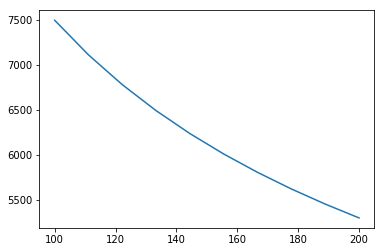

In [41]:
#plt.plot(freqs,jy_beam_pt)
#plt.plot(freqs,jy_beam_disc)
plt.plot(freqs,eq11)
#plt.plot(freqs,test)
plt.show()

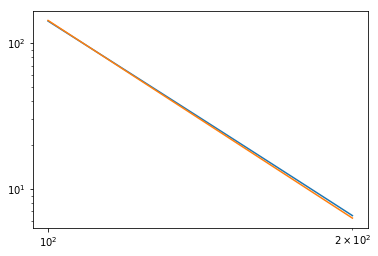

In [59]:
plt.loglog(freqs,jy_beam_pt*omega_B)
plt.loglog(freqs,23.*np.power(freqs/(150.*u.MHz),-4.5))

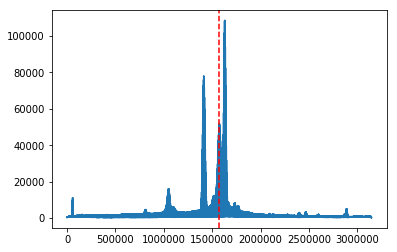

In [21]:
%matplotlib inline
plt.plot(maps[0])
plt.axvline(ipix_gc,color='red',linestyle='--')
plt.show()

In [61]:
3709.*np.power(160./408.,-2.5)

38512.994215231804

In [62]:
freqs

<Quantity [ 100.        , 111.11111111, 122.22222222, 133.33333333,
            144.44444444, 155.55555556, 166.66666667, 177.77777778,
            188.88888889, 200.        ] MHz>

In [63]:
jy_beam_disc[5]

10312.634089385707

In [19]:
300./1024.*100.

29.296875

In [20]:
np.log(3.)

1.0986122886681098

In [21]:
def pwr(nu,nu0,alpha):
    return np.power(nu/nu0,-alpha)

In [24]:
print pwr(150.,150.,-1.)
print pwr(180.,150.,-2.5)

1.0
1.5774409656148782


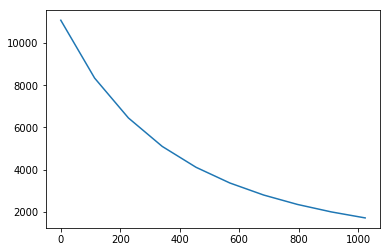

In [44]:
plt.plot((freqs.value-100.)*1024./100.,3709.*pwr(freqs,150.,2.7))

In [3]:
def Saul11(nu):
    return 3709*np.power(nu/408.,-0.5)

In [5]:
freqs

<Quantity [100.        , 111.11111111, 122.22222222, 133.33333333,
           144.44444444, 155.55555556, 166.66666667, 177.77777778,
           188.88888889, 200.        ] MHz>

(0, 8000)

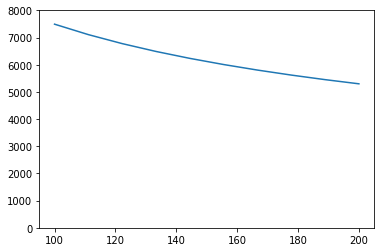

In [8]:
plt.plot(freqs,Saul11(freqs))
plt.ylim([0,8000])

In [9]:
350./1024.*100.+100.

134.1796875

In [10]:
(0.05*u.rad).to(u.deg)

<Quantity 2.86478898 deg>

In [11]:
freqs

<Quantity [100.        , 111.11111111, 122.22222222, 133.33333333,
           144.44444444, 155.55555556, 166.66666667, 177.77777778,
           188.88888889, 200.        ] MHz>

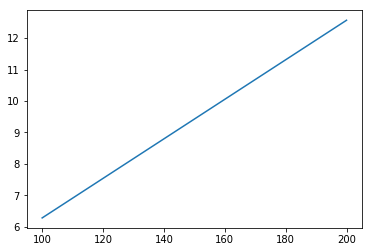

In [12]:
plt.plot(freqs,(2.*np.pi*10.*u.ns*freqs).to(u.dimensionless_unscaled))

In [13]:
(10*u.ns*150*u.MHz).to(u.dimensionless_unscaled)

<Quantity 1.5>

In [17]:
((12.*u.deg).to(u.rad).value/(2.*np.pi)/(100.*u.MHz)).to(u.ns)

<Quantity 0.33333333 ns>